In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split 
from sklearn.datasets import make_blobs 
from sklearn import svm

from h import *
from W_unitary import *
from U_unitary import *
from qiskit.algorithms.optimizers import COBYLA, ADAM, SPSA, SLSQP, POWELL, L_BFGS_B, TNC, AQGD

%matplotlib inline
#plt.rcParams['figure.figsize'] = (10,6)
#plt.rcParams['figure.dpi'] = 100
#sns.set()

#%matplotlib inline
#%load_ext autoreload
#%autoreload 2

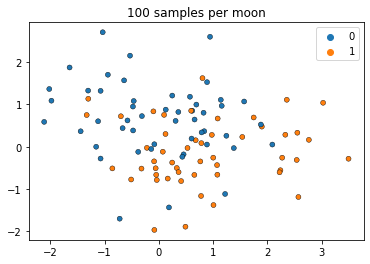

In [2]:
X, y = make_moons(n_samples=100, noise=0.8)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, marker="o", s=25, edgecolor="k", legend=True).set_title("100 samples per moon")
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [3]:
RANDOM_STATE=42
seed = np.random.seed(RANDOM_STATE)
Theta = 2*np.pi*np.random.random(2*2*3)
print(Theta)

[2.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248
 0.3649501  5.44234523 3.77691701 4.44895122 0.12933619 6.09412333]


In [4]:
shots=1024
predictions = []
for i in range(0, len(y_train)):
    predictions.append(h(X_train[i], Theta, 2, 2, shots))
print(predictions)



[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1]


In [5]:
def MSE_loss(Theta, y_train):
    
    new_y_train = []
    for i in range(0, len(y_train)):
        if y_train[i] == 0:
            new_y_train.append(-1)
        else:
            new_y_train.append(1)
    
    shots=1024
    predictions = []
    for i in range(0, len(y_train)):
        predictions.append(h(X_train[i], Theta, 2, 2, shots))
    
    error = []
    for i in range(0, len(predictions)):
        parity = predictions[i] - y_train[i]
        error.append(parity)

    norm = np.linalg.norm(error)
    print(norm)
    return norm

In [6]:
objective_function = lambda Theta: MSE_loss(Theta, y_train)

In [11]:
optimizer = ADAM(maxiter=100)
print(optimizer)
# output = optimizer.optimize(len(Theta), objective_function, initial_point=Theta)

In [8]:
print(output[0])
print(len(output[0]))

[2.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248
 0.3649501  5.44234523 3.77691701 4.44895122 0.12933619 6.09412333]
12


In [9]:
print(Theta)

[2.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248
 0.3649501  5.44234523 3.77691701 4.44895122 0.12933619 6.09412333]
